# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цели исследования:**

1. Построить модель для определения региона, где добыча принесёт наибольшую прибыль. 
2. Анализ возможной прибыли и рисков техникой Bootstrap.

**Ход исследования**
<br>
1. Загрузка, изучение и подготовка данных. 
<br>
Загрузим данные, изучим их, подготовим к дальнейшей работе.
<br>
<br>
2. Обучение и проверка модели для каждого региона.
<br>
На этом этапе
- разбейте данные на обучающую и валидационную выборки в соотношении 75:25;
- обучим модель и сделаем предсказания на валидационной выборке;
- сохраним предсказания и правильные ответы на валидационной выборке;
- выведем средний запас предсказанного сырья и RMSE модели;
- проанализируем результаты.
<br>
3. Подготовка к расчёту прибыли
<br>
- сохраним все ключевые значения для расчётов в отдельных переменных;
- рассчитаем достаточный объём сырья для безубыточной разработки новой скважины;
- сравним полученный объём сырья со средним запасом в каждом регионе;
- сделаем выводы по этапу подготовки расчёта прибыли.
<br>
4. Вывод функции для расчёта прибыли по выбранным скважинам и предсказаниям модели.
<br>
- выберем скважины с максимальными значениями предсказаний;
- просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям;
- рассчитаем прибыль для полученного объёма сырья.
<br>
5. Просчёт рисков и прибыли для каждого региона. 
<br>
- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;
- найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков;
- напишем выводы, предложим регион для разработки скважин и обоснуем выбор.
<br>
<br>

**Описание данных**
<br>
<br>
Данные геологоразведки трёх регионов находятся в файлах: 
<br>
<br>
/datasets/geo_data_0.csv
<br>
/datasets/geo_data_1.csv
<br>
/datasets/geo_data_2.csv
<br>
<br>
id — уникальный идентификатор скважины;
<br>
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
<br>
product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from scipy import stats as st
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

**Проверяем данные геологоразведки первого региона**

In [3]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️ <a class="tocSkip"> </h2>

В данном проекте мы работаем с данными одинаковой природы, а это значит, что большинство расчетов для регионов будут повторяться. Это отличная возможность потренироваться над оптимизацией кода. Например, вот здесь. Первичное знакомство с данными можно было реализовать в функции и вызывать эту функцию для каждого из датафреймов (в цикле в идеале). В нее можно включить все основные методы типа `head`, `info` и т.д.  Можно графики строить какие-нибудь... Из готового, я бы рекомендовал почитать про [pandas_profiling](https://habr.com/ru/company/ruvds/blog/451478/?)


In [4]:
data_0.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99990,bxg6G,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.500419,0.871832,-1.408605,-0.07258,0.50236,1.073581,2.362331
f1,100000.0,NaN,NaN,NaN,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,NaN,NaN,NaN,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.00379
product,100000.0,NaN,NaN,NaN,92.5,44.288691,0.0,56.497507,91.849972,128.564089,185.364347


In [5]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
display(data_0.duplicated().sum())

0

In [7]:
is_duplicated_0 = data_0['id'].duplicated().any()
print("Наличие повторяющихся записей в датасете data_0:", is_duplicated_0)

Наличие повторяющихся записей в датасете data_0: True


In [8]:
data_0['id'].value_counts()

bxg6G    2
A5aEY    2
74z30    2
TtcGQ    2
fiKDv    2
        ..
mYxTV    1
0m7a8    1
lfW3N    1
GrWan    1
dmqjg    1
Name: id, Length: 99990, dtype: int64

**Проверяем данные геологоразведки второго региона**

In [9]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
data_1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,bfPNe,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,NaN,NaN,NaN,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,NaN,NaN,NaN,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,NaN,NaN,NaN,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408


In [11]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
display(data_1.duplicated().sum())

0

In [13]:
is_duplicated_1 = data_1['id'].duplicated().any()
print("Наличие повторяющихся записей в датасете data_1:", is_duplicated_1)

Наличие повторяющихся записей в датасете data_1: True


In [14]:
data_1['id'].value_counts()

bfPNe    2
LHZR0    2
5ltQ6    2
wt4Uk    2
6Xt3f    1
        ..
GfSsf    1
zJGhx    1
RIBqJ    1
Z02NV    1
ZnvMd    1
Name: id, Length: 99996, dtype: int64

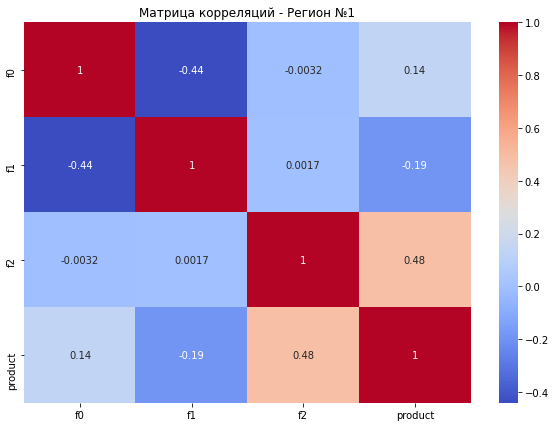

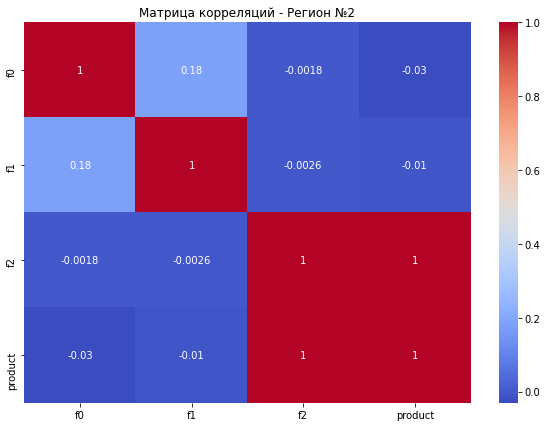

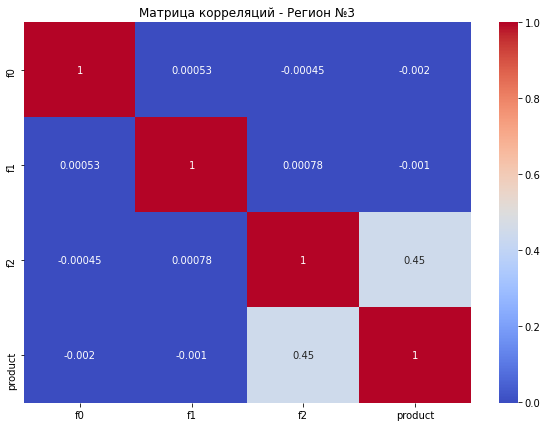

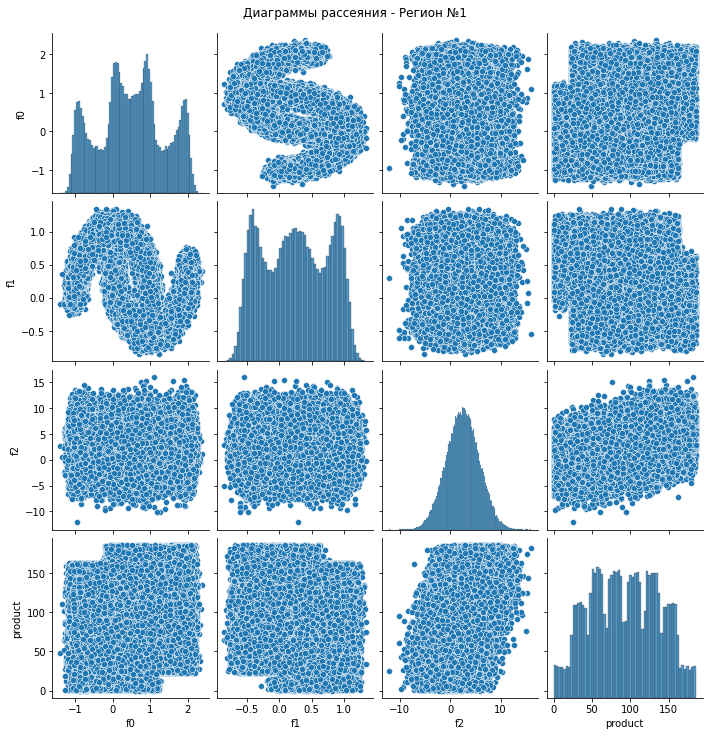

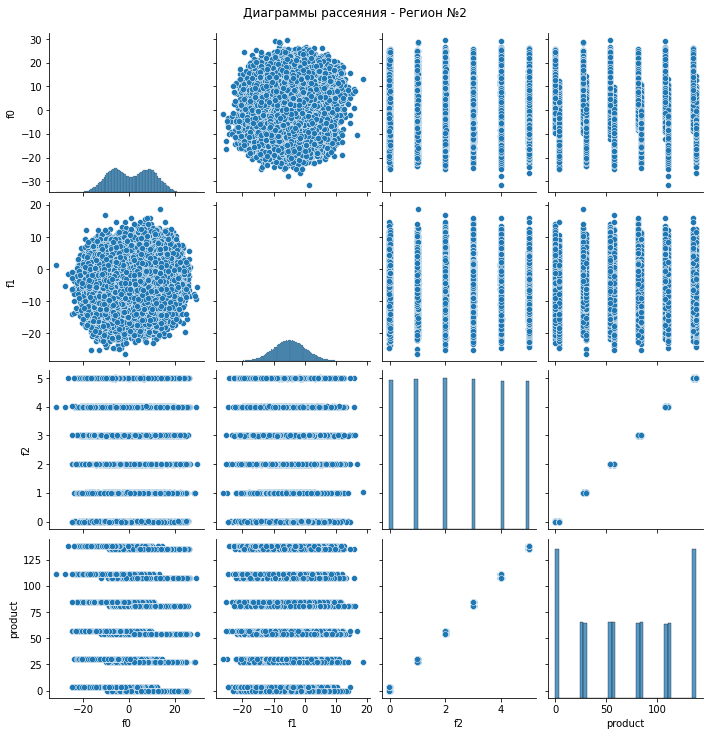

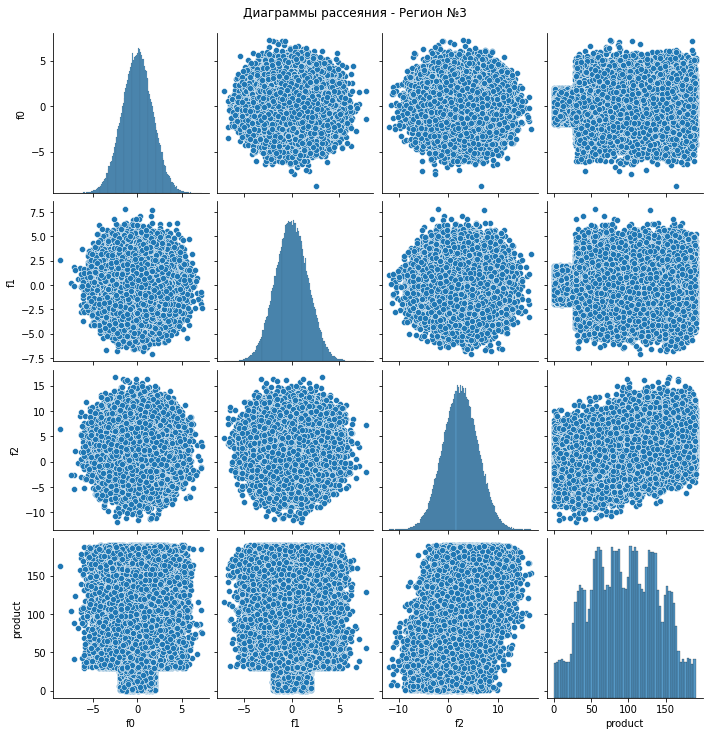

In [15]:


# вычисляем матрицы корреляций
corr_0 = data_0.corr()
corr_1 = data_1.corr()
corr_2 = data_2.corr()

# сторим тепловые карты корреляций
plt.figure(figsize=(10, 7))
sns.heatmap(corr_0, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций - Регион №1')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_1, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций - Регион №2')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_2, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций - Регион №3')
plt.show()

# строим диаграммы рассеяния 
sns.pairplot(data_0[['f0', 'f1', 'f2', 'product']])
plt.suptitle('Диаграммы рассеяния - Регион №1', y=1.02)
plt.show()

sns.pairplot(data_1[['f0', 'f1', 'f2', 'product']])
plt.suptitle('Диаграммы рассеяния - Регион №2', y=1.02)
plt.show()

sns.pairplot(data_2[['f0', 'f1', 'f2', 'product']])
plt.suptitle('Диаграммы рассеяния - Регион №3', y=1.02)
plt.show()


**Проверяем данные геологоразведки третьего региона**

In [16]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [17]:
data_2.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,KUPhW,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,NaN,NaN,NaN,-0.002081,1.730417,-7.08402,-1.17482,-0.009482,1.163678,7.844801
f2,100000.0,NaN,NaN,NaN,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,NaN,NaN,NaN,95.0,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


In [18]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [19]:
display(data_2.duplicated().sum())

0

**Вывод по знакомству с данными:**
<br>
- пропусков и дубликатов нет;
- три датафрейма одинакового размера и одного масштаба;  
- признаки – численные.

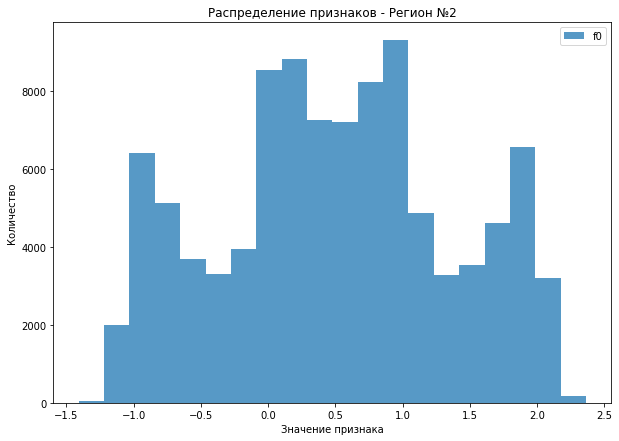

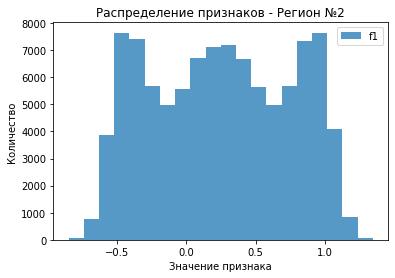

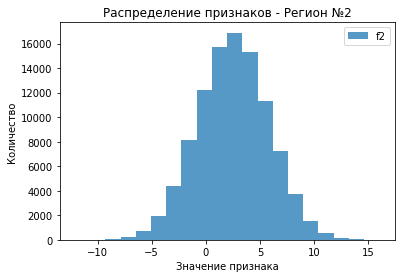

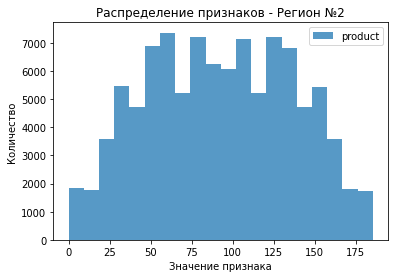

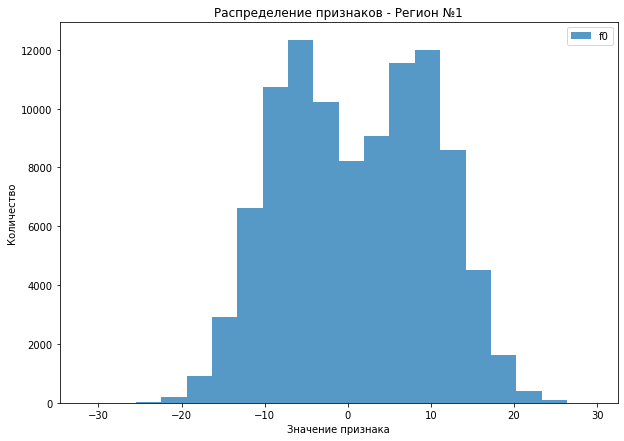

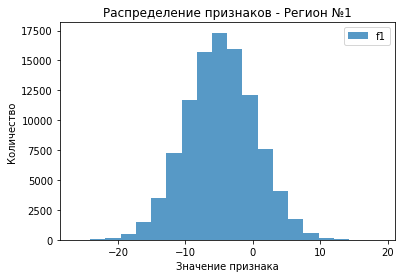

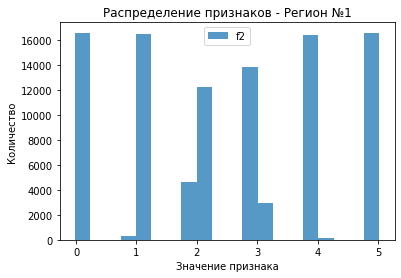

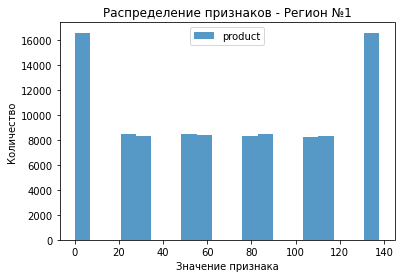

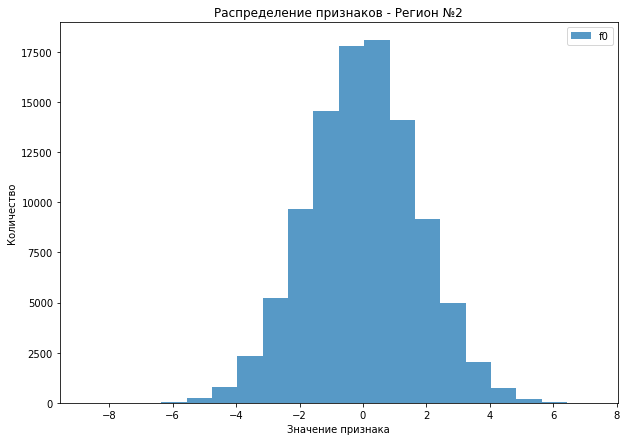

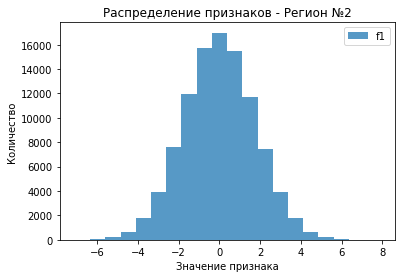

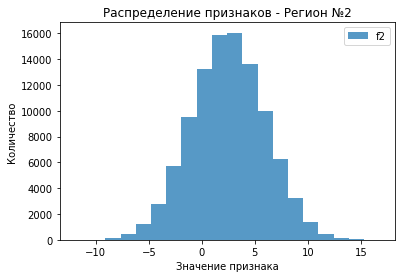

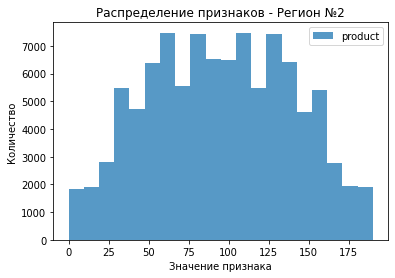

In [20]:
# построим графики распределений признаков для каждого региона

# регион №1
plt.figure(figsize=(10, 7))
for column in data_0.drop('id', axis=1).columns:
    plt.hist(data_0[column], bins=20, alpha=0.75, label=column)
    plt.xlabel('Значение признака')
    plt.ylabel('Количество')
    plt.title('Распределение признаков - Регион №2')
    plt.legend()
    plt.show()
    
# регион №2
plt.figure(figsize=(10, 7))
for column in data_1.drop('id', axis=1).columns:
    plt.hist(data_1[column], bins=20, alpha=0.75, label=column)
    plt.xlabel('Значение признака')
    plt.ylabel('Количество')
    plt.title('Распределение признаков - Регион №1')
    plt.legend()
    plt.show()
    
# регион №3  
plt.figure(figsize=(10, 7))
for column in data_2.drop('id', axis=1).columns:
    plt.hist(data_2[column], bins=20, alpha=0.75, label=column)
    plt.xlabel('Значение признака')
    plt.ylabel('Количество')
    plt.title('Распределение признаков - Регион №2')
    plt.legend()
    plt.show()

## Обучение и проверка модели

**Обучение и проверка модели по данными первого региона**

Разделим данные первого региона на обучающую (75%) и валидационную (25%) выборки.

In [21]:
data_0_train, data_0_valid = train_test_split(data_0, test_size=.25, random_state=12345)
display(data_0_train.shape)
data_0_valid.shape

(75000, 5)

(25000, 5)

В признаки записываем данные из выборок, исключаем ненужные столбцы. Целевой признак – столбец product

In [22]:

features_train_0 = data_0_train.drop(['id', 'product'], axis=1)
target_train_0 = data_0_train['product']
features_valid_0 = data_0_valid.drop(['id', 'product'], axis=1)
target_valid_0 = data_0_valid['product']

Обучаем модель логистической регрессии для первого региона

In [23]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predictions_valid_0 = model_0.predict(features_valid_0)

Вычисляем RMSE первого региона

In [24]:
rmse_0 = mean_squared_error(target_valid_0, predictions_valid_0) ** .5
rmse_0

37.5794217150813

Вычислим средний запас предсказанного сырья для первого региона

In [25]:
product_mean_0 = predictions_valid_0.mean()
product_mean_0

92.59256778438035

Отклонение по первому региону – 37.6;
<br>
Средний запас предсказанного сырья по первому региону – 92.6.



**Обучение и проверка модели по данными второго региона**

Разделим данные второго региона на обучающую (75%) и валидационную (25%) выборки.

In [26]:
data_1_train, data_1_valid = train_test_split(data_1, test_size=.25, random_state=12345)
display(data_1_train.shape)
data_1_valid.shape

(75000, 5)

(25000, 5)

В признаки записываем данные из выборок, исключаем ненужные столбцы. Целевой признак – столбец product

In [27]:
features_train_1 = data_1_train.drop(['id', 'product'], axis=1)
target_train_1 = data_1_train['product']
features_valid_1 = data_1_valid.drop(['id', 'product'], axis=1)
target_valid_1 = data_1_valid['product']

Обучаем модель логистической регрессии для второго региона

In [28]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predictions_valid_1 = model_1.predict(features_valid_1)

Вычисляем RMSE второго региона

In [29]:
rmse_1 = mean_squared_error(target_valid_1, predictions_valid_1) ** .5
rmse_1

0.893099286775617

Вычислим средний запас предсказанного сырья для второго региона

In [30]:
product_mean_1 = predictions_valid_1.mean()
product_mean_1

68.728546895446

Отклонение по второму региону – 0.89;
<br>
Средний запас предсказанного сырья по второму региону – 68.7.

**Обучение и проверка модели по данными третьего региона**

Разделим данные третьего региона на обучающую (75%) и валидационную (25%) выборки.

In [31]:
data_2_train, data_2_valid = train_test_split(data_2, test_size=.25, random_state=12345)
display(data_2_train.shape)
data_2_valid.shape

(75000, 5)

(25000, 5)

В признаки записываем данные из выборок, исключаем ненужные столбцы. Целевой признак – столбец product

In [32]:
features_train_2 = data_2_train.drop(['id', 'product'], axis=1)
target_train_2 = data_2_train['product']
features_valid_2 = data_2_valid.drop(['id', 'product'], axis=1)
target_valid_2 = data_2_valid['product']

Обучаем модель логистической регрессии для третьего региона

In [33]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predictions_valid_2 = model_2.predict(features_valid_2)

Вычисляем RMSE третьего региона

In [34]:
rmse_2 = mean_squared_error(target_valid_2, predictions_valid_2) ** .5
rmse_2

40.02970873393434

Вычислим средний запас предсказанного сырья для третьего региона

In [35]:
product_mean_2 = predictions_valid_2.mean()
product_mean_2

94.96504596800489

Отклонение по третьему региону – 40;
<br>
Средний запас предсказанного сырья по третьему региону – 95.

Вывод по работе с данными трёх регионов:
- отклонение в трех регионах равны 37.6, 0.89, 40;
- средний запас в трех регионах равно 92.6, 68.7, 95.

## Подготовка к расчёту прибыли

При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выбирем 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей.
После оценки рисков нужно оставим те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирем регион с наибольшей средней прибылью.


In [36]:
# преобразуем целевые признаки и предсказания моделей в объект Series
target_valid_0 = pd.Series(target_valid_0).reset_index(drop=True)
predictions_valid_0 = pd.Series(predictions_valid_0).reset_index(drop=True)

target_valid_1 = pd.Series(target_valid_1).reset_index(drop=True)
predictions_valid_1 = pd.Series(predictions_valid_1).reset_index(drop=True)

target_valid_2 = pd.Series(target_valid_2).reset_index(drop=True)
predictions_valid_2 = pd.Series(predictions_valid_2).reset_index(drop=True)

In [37]:
WELLS_COUNT_TOTAL = 500
BEST_WELLS_COUNT  = 200
BUDGET = 10000000000
BARREL_INCOME = 450000
INCOME_ONE_BARREL = 450 
NUMBER = 1000

In [38]:
average_product = BUDGET / BARREL_INCOME / BEST_WELLS_COUNT
display(average_product)

111.11111111111111

Для безубыточной добычи топлива средний запас сырья скважин в каждом разрабатываемом регионе должен быть не ниже 111 баррелей.

Сравним полученный объём со средним запасом в каждом регионе

In [39]:
# первый регион
data_0['profit']=(data_0['product']*(INCOME_ONE_BARREL)).round(2) 
average_product_0 = data_0['product'].mean()
data_0.head()

,id,f0,f1,f2,product,profit
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49


In [40]:
print('Разница между уровнем безубыточной добычи и средним значением по первому региону составляет {:.2%}'.format(
    average_product_0/average_product-1))

Разница между уровнем безубыточной добычи и средним значением по первому региону составляет -16.75%


In [41]:
# второй регион
data_1['profit']=(data_1['product']*(INCOME_ONE_BARREL)).round(2) 
average_product_1 = data_1['product'].mean()
data_1.head()

,id,f0,f1,f2,product,profit
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84


In [42]:
print('Разница между уровнем безубыточной добычи и средним значением по первому региону составляет {:.2%}'.format(
    average_product_1/average_product-1))

Разница между уровнем безубыточной добычи и средним значением по первому региону составляет -38.06%


In [43]:
# третий регион
data_2['profit']=(data_1['product']*(INCOME_ONE_BARREL)).round(2)
average_product_2 = data_2['product'].mean()
data_2.head()

,id,f0,f1,f2,product,profit
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,1430.60
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,12128.97
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,60644.84
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,62075.43
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,60644.84


In [44]:
print('Разница между уровнем безубыточной добычи и средним значением по первому региону составляет {:.2%}'.format(
    average_product_2/average_product-1))

Разница между уровнем безубыточной добычи и средним значением по первому региону составляет -14.50%


Вывод: среднее количество запасов сырья по всем трём регионам недостаточно для уровня безубыточной добычи.

## Расчёт прибыли и рисков 

Создадим функцию, расчитывающую прибыль по предсказаниям модели и выбранным скважинам

In [45]:
def revenue(target, predictions, COUNT):
    preds_sorted = predictions.sort_values(ascending=False)
    selected = target[preds_sorted.index][:BEST_WELLS_COUNT]
    return BARREL_INCOME * selected.sum() - BUDGET

In [46]:
revenue(target_valid_0, predictions_valid_0, BEST_WELLS_COUNT)

3320826043.1398506

In [47]:
predictions_valid_0

0         95.894952
1         77.572583
2         77.892640
3         90.175134
4         70.510088
            ...    
24995    103.037104
24996     85.403255
24997     61.509833
24998    118.180397
24999    118.169392
Length: 25000, dtype: float64

In [48]:
# привяжем индексы скважин к предсказаниям
wells_sorted_0 = pd.Series(predictions_valid_0, index=target_valid_0.index).sort_values(ascending=False)
selected_best_0 = wells_sorted_0[:200]
selected_best_0

9317     180.180713
219      176.252213
10015    175.850623
11584    175.658429
23388    173.299686
            ...    
7888     148.507064
7890     148.481767
24051    148.476498
24160    148.436761
20340    148.365941
Length: 200, dtype: float64

In [49]:
# суммируем целевое значение объёма сырья
selected_best_0_sum = selected_best_0.sum()
print('Запас сырья в 200 лучших скважинах: %.2f тыс.баррелей'%selected_best_0_sum)

Запас сырья в 200 лучших скважинах: 31102.33 тыс.баррелей


In [50]:
# рассчитываем прибыль для полученного объёма сырья
profit_pred_0=(selected_best_0_sum*INCOME_ONE_BARREL)-(BUDGET/1000)
print('Прибыль полученного объёма сырья %.2f тыс.рублей'%profit_pred_0)

Прибыль полученного объёма сырья 3996048.88 тыс.рублей


In [51]:
#заносим в функцию
def profit (predict,target,count):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_max = probs_sorted[:count].sum()
    profit_pred=(selected_max*INCOME_ONE_BARREL)-BUDGET/1000
    print('Сумма запаса сырья в 200 лучших скважинах: %.2f тыс.баррелей'%selected_max)
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000))

In [52]:
# прибыль для первого региона
profit(predictions_valid_0,target_valid_0,200)

Сумма запаса сырья в 200 лучших скважинах: 31102.33 тыс.баррелей
Прибыль для полученного объёма сырья составит 3996.05 млн.рублей


In [53]:
# прибыль для второго региона
profit(predictions_valid_1,target_valid_1,200)

Сумма запаса сырья в 200 лучших скважинах: 27746.03 тыс.баррелей
Прибыль для полученного объёма сырья составит 2485.71 млн.рублей


In [54]:
# прибыль для третьегоо региона
profit(predictions_valid_2,target_valid_2,200)

Сумма запаса сырья в 200 лучших скважинах: 29603.90 тыс.баррелей
Прибыль для полученного объёма сырья составит 3321.75 млн.рублей


Вывод: все регионы потенциально прибыльные. 

Рассчитаем риски и прибыль для регионов. Применим технику bootstrap c 1000 выборок для определения средней возможной прибыли и вероятности убытков по регионам

Регион №1
Средняя прибыль: 396164984.8023711
95%-доверительный интервал: от -111215545.89049526 до 909766941.5534226
Вероятность убытков: 6.9 %


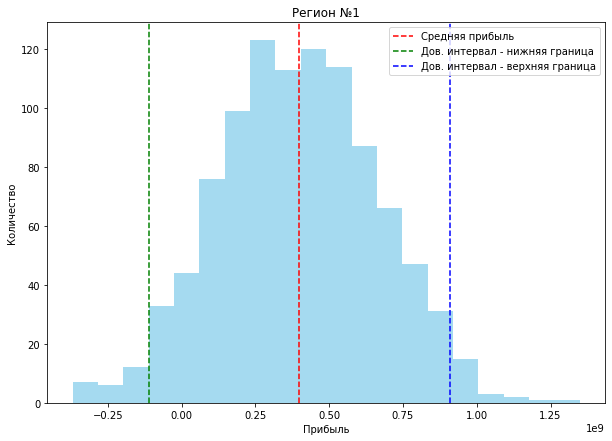

Регион №2
Средняя прибыль: 461155817.2772397
95%-доверительный интервал: от 78050810.7517417 до 862952060.2637234
Вероятность убытков: 0.7000000000000001 %


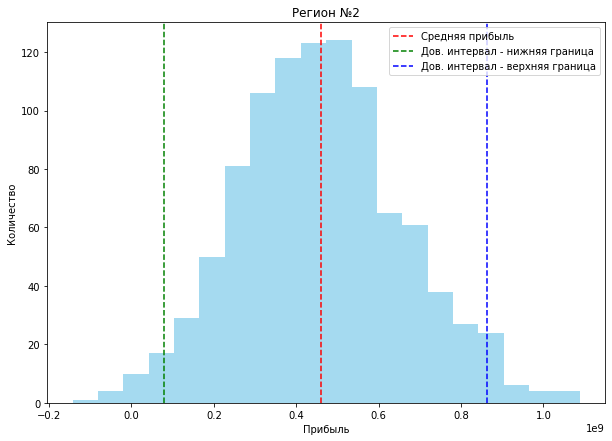

Регион №3
Средняя прибыль: 392950475.17060447
95%-доверительный интервал: от -112227625.37857565 до 934562914.5511636
Вероятность убытков: 6.5 %


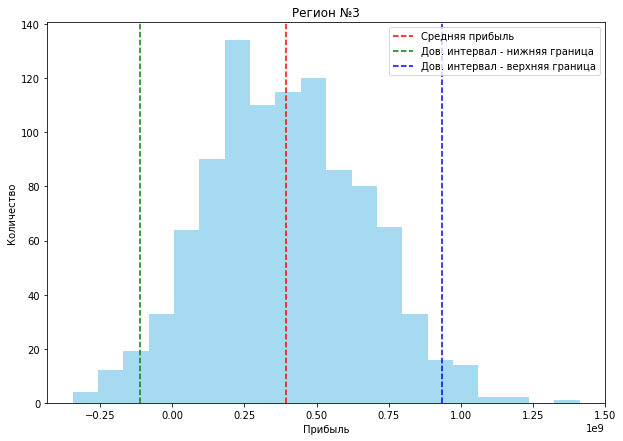

In [55]:
target = [target_valid_0, target_valid_1, target_valid_2]
predictions = [predictions_valid_0, predictions_valid_1, predictions_valid_2]
regions = ['Регион №1', 'Регион №2', 'Регион №3']

state = np.random.RandomState(12345)

for m in range(len(target)):
    values = []
    for i in range(NUMBER):
        target_subsample = target[m].sample(n=WELLS_COUNT_TOTAL, replace=True, random_state=state)
        predictions_subsample = predictions[m].loc[target_subsample.index]
        values.append(revenue(target_subsample.reset_index(drop=True), predictions_subsample.reset_index(drop=True), BEST_WELLS_COUNT))

    values = pd.Series(values)
    lower = values.quantile(.025)
    upper = values.quantile(.975)

    mean = values.mean()
    
    #loss_probability = sum(values <= 0) / values.count() * 100
    loss_probability = (values < 0).mean()* 100
#     loss_probability = scipy.stats.percentileofscore(values, 3, kind='mean')
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.hist(values, bins=20, color='skyblue', alpha=0.75)
    ax.axvline(x=mean, color='red', linestyle='--', label='Средняя прибыль')
    ax.axvline(x=lower, color='green', linestyle='--', label='Дов. интервал - нижняя граница')
    ax.axvline(x=upper, color='blue', linestyle='--', label='Дов. интервал - верхняя граница')
    ax.set_xlabel('Прибыль')
    ax.set_ylabel('Количество')
    ax.set_title(regions[m])
    
    print(regions[m])
    print("Средняя прибыль:", mean)
    print("95%-доверительный интервал:", "от", lower, "до", upper)
    print("Вероятность убытков:", loss_probability, "%")
    
    
    ax.legend()
    plt.show()
    

+------------------------+------------------+
|       Показатель       |     Значение     |
+------------------------+------------------+
|    Средняя выручка     |    507.6 млн     |
|          Риск          |       1.4%       |
| Доверительный интервал | 89.5 : 918.6 млн |
+------------------------+------------------+


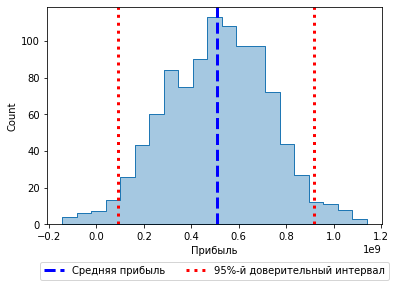

In [57]:
# !pip3 install prettytable
from prettytable import PrettyTable
import seaborn as sns
from scipy import stats as st

BUDGET = 10000000000
BARREL_COST = 450
BARRELS_IN_UNIT = 1000
UNIT_COST = BARREL_COST * BARRELS_IN_UNIT
TOTAL_POINTS = 500
POINTS = 200

def revenue_2(target, predictions, points, budget, unit_cost):
    predicted_sorted = predictions.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:points]
    return selected.sum() * unit_cost - budget

def bootstrap_2(target, probabilities):
    state = np.random.RandomState(888)
    values=[]
    for i in range(1000):
        target_subsample = target.sample(replace=True,\
            random_state=state, n=TOTAL_POINTS)
        
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue_2(target_subsample, probs_subsample, POINTS, BUDGET, UNIT_COST))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = st.percentileofscore(values, 0)
     
     # Отображение таблицы
    table = PrettyTable()
    table.field_names = ['Показатель', 'Значение']    
    table.add_row(['Средняя выручка', f'{mean/1e6:.1f} млн'])
    table.add_row(['Риск', f'{risk:.2}%'])    
    table.add_row(['Доверительный интервал', f'{lower/1e6:.1f} : {upper/1e6:.1f} млн'])
    print(table)

    sns.histplot(values, alpha=0.4,  element="step")
    plt.xlabel('Прибыль')
    plt.axvline(x=mean, color='b', ls='--', lw=3, label='Средняя прибыль')
    plt.axvline(x=lower, color='r', ls=':', lw=3, label='95%-й доверительный интервал')
    plt.axvline(x=upper, color='r', ls=':', lw=3)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.show()
    
bootstrap_2(target_valid_1, predictions_valid_1)

Вывод: самая низкая вероятность убытков во втором регионе, в нём же и возможная прибыль самая высокая. Этот регион является самым подходящим для разработки. 

**Общий вывод**

1. На первом этапе загрузили, изучили и подготовили данные.
2. На этапе обучения и проверки модели для каждого региона:
    - разбили данные на обучающую и валидационную выборки 75:25;
    - обучили модель и сделали предсказания на валидационной выборке;
    - вывели средний запас предсказанного сырья и RMSE модели;
    - в результате получили, что самое низкое отклонение во втором регионе 0.89 при среднем запасе 68.7, который среди регионов тоже минимальный.
3. На этапе подготовки к расчёту прибыли:
    - сохранили ключевые значения в отдельных переменных;
    - рассчитали достаточный объём сырья для безубыточной разработки новой скважины, который составил 111 баррелей;
    - сравнили полученный объём сырья со средним запасом в каждом регионе;
    - сделали вывод, что среднее количество запасов сырья по всем трём регионам недостаточно для уровня безубыточной добычи.
4. На этапе расчёта прибыли и рисков:
    - вывели функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели;
    - просчитали риски и прибыль для каждого региона с применением техники Bootstrap с 1000 выборок: вычислили распределение прибыли, нашли среднюю прибыль, 95%-й доверительный интервал и вероятность убытков;
    - предложили второй регион для разработки скважин, поскольку именно по нему самая низкая вероятность убытков и высокий прогноз по прибыли.